# Espectro de un solo transmon
En este notebook encontramos comparamos diferencias en el espectro del transmon tomando distintas aproximaciones. El hamiltoniano del transmon es
$$
\hat H = 4E_c\hat n^2 - E_J \cos(\hat \delta)
$$
siendo $\hat n$ y $\hat \delta$ variables canónicamente conjugadas ($[\hat \delta, \hat n] = i$). En el régimen del transmon $E_J \gg E_c$ lo cual nos permite hacer una expansión en serie de potencias del coseno por lo cual, descartando términos constantes
$$
\hat  H \approx 4E_c\hat n^2 + \frac{E_J}{2}\hat \delta^2 - \frac{E_J}{24} \hat \delta^4  
$$
Definiendo 
$$
\hat \delta = \left(\frac{2E_C}{E_J}\right)^{1/4} (\hat b^\dag + \hat b),
$$
$$
\hat n = \frac{i}{2}\left(\frac{E_J}{2E_C}\right)^{1/4} (\hat b^\dag - \hat b)
$$
llegamos a la siguiente expresión
$$
\hat H \approx \hbar \omega_0 \hat b^\dag \hat b - \hbar \lambda(\hat b^\dag + \hat b)^4
$$
con $\hbar \omega_0 = \sqrt{8E_c E_J}$ y $\hbar \lambda = \frac{E_c}{12}$. Tras expandir el último término, este puede ser escrito como:
$$
(\hat b + \hat b^\dag)^4 = \hat O_4 + \hat O_2 + \hat O_0
$$
con $O_k$ la parte del operador que cambia al estado en $k$ excitaciones:
$$
\hat O_4 = \hat b^4 + (\hat b^{\dag})^4
$$
$$
\hat O_2 = 4\left((\hat b^\dag)^3 \hat b + \hat b^\dag \hat b^3\right) + 6\left(\hat b^2 + (\hat b^\dag)^2\right)
$$
$$
\hat O_0 = 6(\hat b^\dag)^2 \hat b^2 + 12\hat b^\dag \hat b
$$

In [135]:
import numpy as np
import matplotlib.pyplot as plt 
import qutip as qt
from scipy.special import genlaguerre, gammaln
import scienceplots
plt.style.use(['science', 'notebook'])

In [136]:
# expresion analitica para la matriz (en base de fock) del operador e^{i u (\hat a + \hat a^\dag)}
# def compute_position_exponential(N, u): 
#   matrix = np.zeros(shape= (N, N), dtype = complex)
#   for m in range(N):
#     for n in range(N):
#       if m >= n:
#         matrix[m][n] = np.exp(-u**2/2) * np.sqrt(factorial(n)/factorial(m)) * (1.0j*u)**(m-n)*genlaguerre(n, m-n)(u**2)
#       else:
#         matrix[m][n] = np.exp(-u**2/2) * np.sqrt(factorial(m)/factorial(n)) * (1.0j*u)**(n-m)*genlaguerre(m, n-m)(u**2)

#   return qt.Qobj(matrix)
def compute_position_exponential(N, u): 
  matrix = np.zeros(shape=(N, N), dtype=complex)
  for m in range(N):
    for n in range(N):
      if m >= n:
        matrix[m][n] = (
          np.exp(-u**2/2)
          * np.exp(0.5 * (gammaln(n+1) - gammaln(m+1)))
          * (1.0j*u)**(m-n)
          * genlaguerre(n, m-n)(u**2)
        )
      else:
        matrix[m][n] = (
          np.exp(-u**2/2)
          * np.exp(0.5 * (gammaln(m+1) - gammaln(n+1)))
          * (1.0j*u)**(n-m)
          * genlaguerre(m, n-m)(u**2)
        )

  return qt.Qobj(matrix)

# hamiltoniano exacto con dimensión truncada en N estados de Fock
def exact_transmon_hamiltonian(N, E_c, E_j):
    charge_number = 0.5j * (E_j/(2*E_c))**0.25 * (qt.destroy(N).dag() - qt.destroy(N))
    phase_prefactor = (2 * E_c / E_j)**0.25
    cos_delta = 0.5 * (compute_position_exponential(N, phase_prefactor) + compute_position_exponential(N, -phase_prefactor))
    return 4 * E_c * charge_number**2 - E_j * cos_delta

# términos para el término de orden 4
def O_0(N):
  return 6 * qt.destroy(N).dag()**2 * qt.destroy(N)**2 + 12 * qt.num(N)

def O_2(N):
  return 4 * (qt.destroy(N).dag()**3 * qt.destroy(N) + qt.destroy(N).dag() * qt.destroy(N)**3) + 6 * (qt.destroy(N)**2 + qt.destroy(N).dag()**2)

def O_4(N):
  return qt.destroy(N)**4 + qt.destroy(N).dag()**4

In [137]:
EJ_values = np.linspace(10.0, 50.0)
E_c = 1.0
N_values = [2, 5, 10, 20]
energies = []

for i, N in enumerate(N_values):
    energy_matrix = np.zeros((len(EJ_values), N))
    
    for j, E_J in enumerate(EJ_values):
        exact_hamiltonian = exact_transmon_hamiltonian(N, E_c, E_J)
        E = exact_hamiltonian.eigenenergies()
        energy_matrix[j, :] = E
    
    energies.append(energy_matrix)

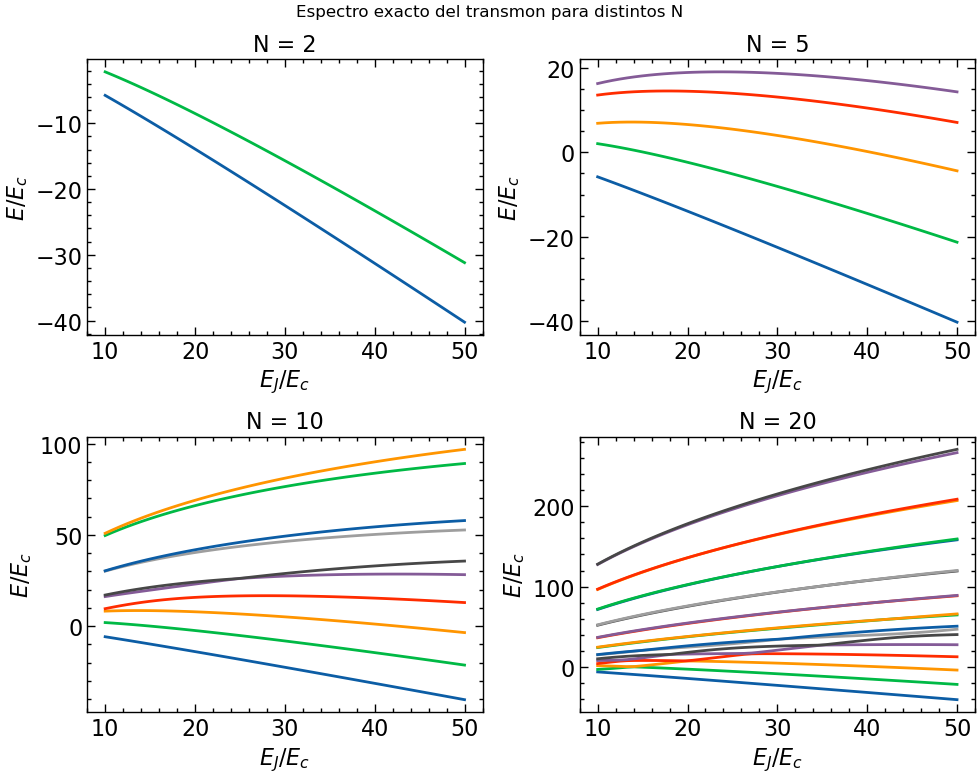

In [138]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
fig.suptitle('Espectro exacto del transmon para distintos N')
# min_y = -40.0
# max_y = 20.0

for i, (n, ax, energy_matrix) in enumerate(zip(N_values, axes.flatten(), energies)):
    ax.set_title(f"N = {n}")
    ax.plot(EJ_values, energy_matrix) 
    ax.set_xlabel('$E_J/E_c$')
    ax.set_ylabel('$E/E_c$')
    # ax.set_ylim(min_y, max_y)
    
fig.tight_layout()
plt.show()

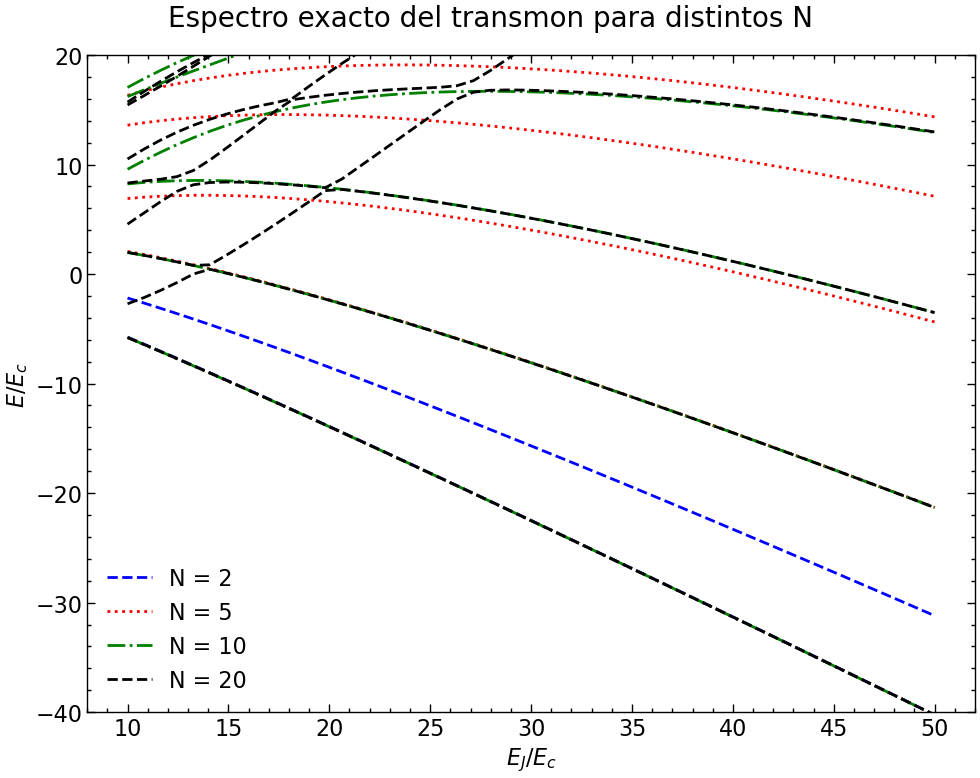

In [139]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Espectro exacto del transmon para distintos N', fontsize = 20)
min_y = -40.0
max_y = 20.0
styles = ['b--', 'r:', 'g-.', 'k--']
ax.set_xlabel('$E_J/E_c$')
ax.set_ylabel('$E/E_c$')
ax.set_ylim(min_y, max_y)

for i, (n, style, energy_matrix) in enumerate(zip(N_values, styles, energies)):
    for level_idx, energy_level in enumerate(energy_matrix.T):
        if level_idx == 0:  # Only label the first energy level
            ax.plot(EJ_values, energy_level, style, label=f'N = {n}')
        else:
            ax.plot(EJ_values, energy_level, style)

plt.legend()
fig.tight_layout()
plt.show()

# Conclusiones del truncamiento? 
Pareciera que en general el error de truncamiento disminuye conforme nos entramos más al régimen transmon ($\frac{E_J}{E_C} \rightarrow \infty$). $N = 2$ es pésimo, no lo usaremos en una primera instancia, $N = 5$ deja de servir a partir del 3er nivel de energía. Por último, si nos fijamos en los primeros 4 niveles de energía, $N= 10$ y $N = 20$ son muy parecidos para $\frac{E_J}{E_C} \gtrsim 30$ mientras que para valores menores difieren bastante cualitativamente.

**En adelante consideraremos como referencia $E_J / E_c \gtrsim 40.0$ y usaremos $N = 8$**. (No probé mayores valores de N por que calculo factoriales y la precisión numérica se va al ...)

# Comparación diagonalización exacta con aproximación

In [ ]:
EJ_values = np.linspace(40.0, 70.0)
E_c = 1.0
lamb = E_c / 12.0
N = 8
# calculamos energias con el hamiltoniano exacto y con los obtenidos por los distintos ordenes de la expansion de Taylor
exact_energies = []
zeroth_order_energies = []
second_order_energies = []
fourth_order_energies = []
for j, E_J in enumerate(EJ_values):
    hbar_omega_0 = np.sqrt(8 * E_c * E_J)
    hamiltonian_0 = hbar_omega_0 * qt.num(N) - lamb * O_0(N)
    hamiltonian_2 = hamiltonian_0 - lamb * O_2(N)
    hamiltonian_4 = hamiltonian_2 - lamb * O_4(N)
    exact_hamiltonian = exact_transmon_hamiltonian(N, E_c, E_J)
    exact_energies.append(np.array(exact_hamiltonian.eigenenergies()))
    zeroth_order_energies.append(np.array(hamiltonian_0.eigenenergies()))
    second_order_energies.append(np.array(hamiltonian_2.eigenenergies()))
    fourth_order_energies.append(np.array(hamiltonian_4.eigenenergies()))
    
exact_energies = np.array(exact_energies)
zeroth_order_energies = np.array(zeroth_order_energies)
second_order_energies = np.array(second_order_energies)
fourth_order_energies = np.array(fourth_order_energies)

In [208]:
exact_differences = exact_energies - exact_energies[:, [0]]
zeroth_differences = zeroth_order_energies - zeroth_order_energies[:, [0]]
second_differences = second_order_energies - second_order_energies[:, [0]]
fourth_differences = fourth_order_energies - fourth_order_energies[:, [0]]

differences_matrix = np.array([zeroth_differences, second_differences, fourth_differences, exact_differences])

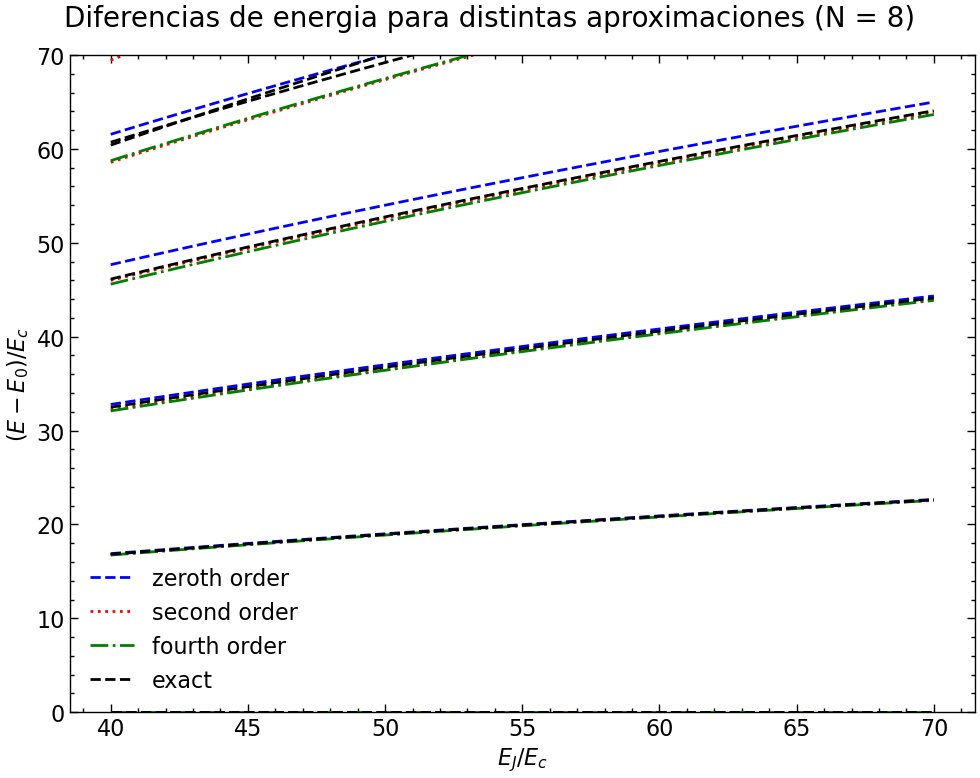

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Diferencias de energia para distintas aproximaciones (N = 8)', fontsize = 20)
styles = ['b--', 'r:', 'g-.', 'k--']
labels = ['zeroth order', 'second order', 'fourth order', 'exact']
ax.set_xlabel('$E_J/E_c$')
ax.set_ylabel('$(E- E_0)/E_c$')
min_y = 0.0
max_y = 70.0
ax.set_ylim(min_y, max_y)
    
for i, (lab, style, energy_matrix) in enumerate(zip(labels, styles, differences_matrix)):
    for level_idx, energy_level in enumerate(energy_matrix.T):
        if level_idx == 0:  # Only label the first energy level
            ax.plot(EJ_values, energy_level, style, label= lab)
        else:
            ax.plot(EJ_values, energy_level, style)

plt.legend()
fig.tight_layout()
plt.show()

Noté que conforme aumentaba la dimensión de truncamiento las aproximaciones se volvían peor y cambiaban demasiado cualitativamente, explicación: por alguna razón al aumentar N, se requiere un mayor orden en la expansión del coseno. Por otro lado, pareciera que está mejor utilizar solo hasta la expansión a términos de segundo orden, los términos de cuarto orden la empeoran.